# Gun Detection

## Clone the Tensorflow Model Garden and install Object Detection API

In [1]:
# clone the Tensorflow Model Garden
!git clone --depth 1 https://github.com/tensorflow/models/

Cloning into 'models'...
remote: Enumerating objects: 3657, done.
remote: Counting objects: 100% (3657/3657), done.
remote: Compressing objects: 100% (3054/3054), done.
remote: Total 3657 (delta 967), reused 1488 (delta 551), pack-reused 0
Receiving objects: 100% (3657/3657), 47.39 MiB | 15.20 MiB/s, done.
Resolving deltas: 100% (967/967), done.


In [2]:
# install the Object Detection API
!cd models/research/ && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/models/research
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 74.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 KB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 80.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 KB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 KB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 662.4/662.4 KB 

## Download the model

In [3]:
# Download data
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet101_v1_640x640_coco17_tpu-8.tar.gz

# untar (decompress) the tar file
!tar -xf faster_rcnn_resnet101_v1_640x640_coco17_tpu-8.tar.gz

--2023-01-17 12:25:15--  http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet101_v1_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.250.4.128, 2404:6800:4003:c02::80
Connecting to download.tensorflow.org (download.tensorflow.org)|142.250.4.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353643040 (337M) [application/x-tar]
Saving to: ‘faster_rcnn_resnet101_v1_640x640_coco17_tpu-8.tar.gz’

faster_rcnn_resnet1 100%[===================>] 337.26M   102MB/s    in 3.3s    

2023-01-17 12:25:19 (102 MB/s) - ‘faster_rcnn_resnet101_v1_640x640_coco17_tpu-8.tar.gz’ saved [353643040/353643040]



## Importing packages

In [4]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from six import BytesIO
from PIL import Image

tf.get_logger().setLevel('ERROR')

# Import Object Detection API utils
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

## Train the model

In [5]:
TRAINING_SCRIPT = "/content/models/research/object_detection/model_main_tf2.py"
model_dir_path  = "/content/drive/MyDrive/model"
pipeline_config = "/content/faster_rcnn_resnet101_v1_640x640_coco17_tpu-8/pipeline.config"

In [7]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=2000".format(
    TRAINING_SCRIPT,
    model_dir_path,
    pipeline_config
)

!{command}

2023-01-17 12:31:11.938066: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-01-17 12:31:11.938189: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-01-17 12:31:11.938211: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
2023-01-17 12:31:15.377914: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environme

## Evaluate the model

In [8]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(
    TRAINING_SCRIPT,
    model_dir_path,
    pipeline_config,
    model_dir_path
)

!{command}

2023-01-17 12:58:40.484456: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-01-17 12:58:40.484659: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-01-17 12:58:40.484684: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
W0117 12:58:43.497416 139742577076096 model_lib_v2.py:1089] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting sample_1_of_n_e

## Load trained model

In [9]:
model_dir_path  = "/content/drive/MyDrive/model"
pipeline_config = "/content/faster_rcnn_resnet101_v1_640x640_coco17_tpu-8/pipeline.config"

configs = config_util.get_configs_from_pipeline_file(pipeline_config)
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(model_dir_path, 'ckpt-3')).expect_partial()

## Detect from an Image

In [10]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [11]:
@tf.function
def detect(input_tensor):
    preprocessed_image, shapes = detection_model.preprocess(input_tensor)
    prediction_dict = detection_model.predict(preprocessed_image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)    
    return detections

In [14]:
category_index = label_map_util.create_category_index_from_labelmap(
    "/content/drive/MyDrive/data/gun-detection.pbtxt"
)

IMAGE_PATH = "/content/tom.jpg"

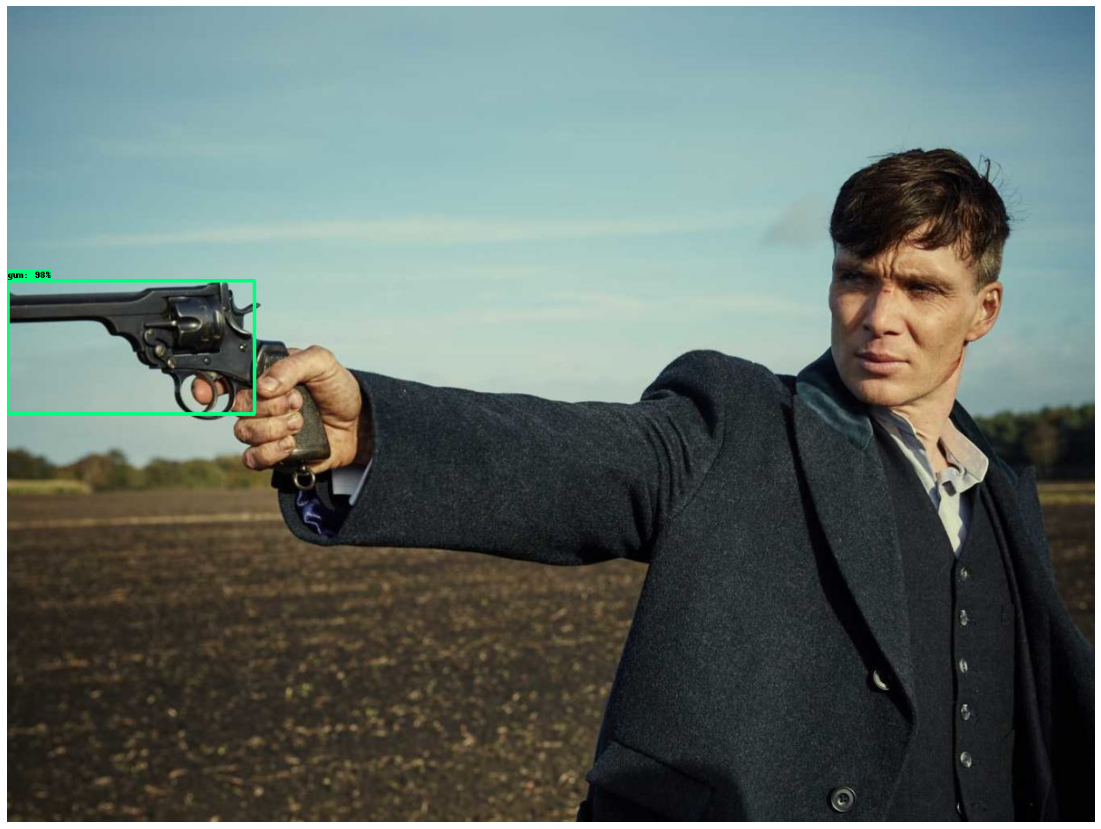

In [15]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)

plt.figure(figsize=(20, 15))
plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

## Try the script

<ipython-input-84-be941433da05>:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20, 15))


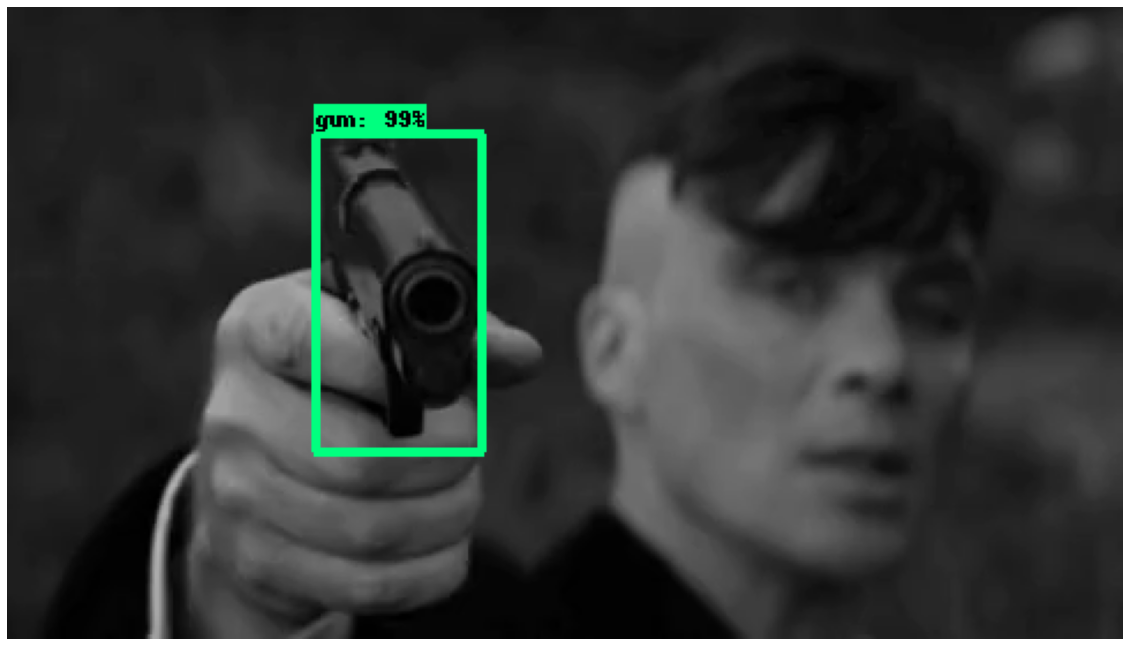

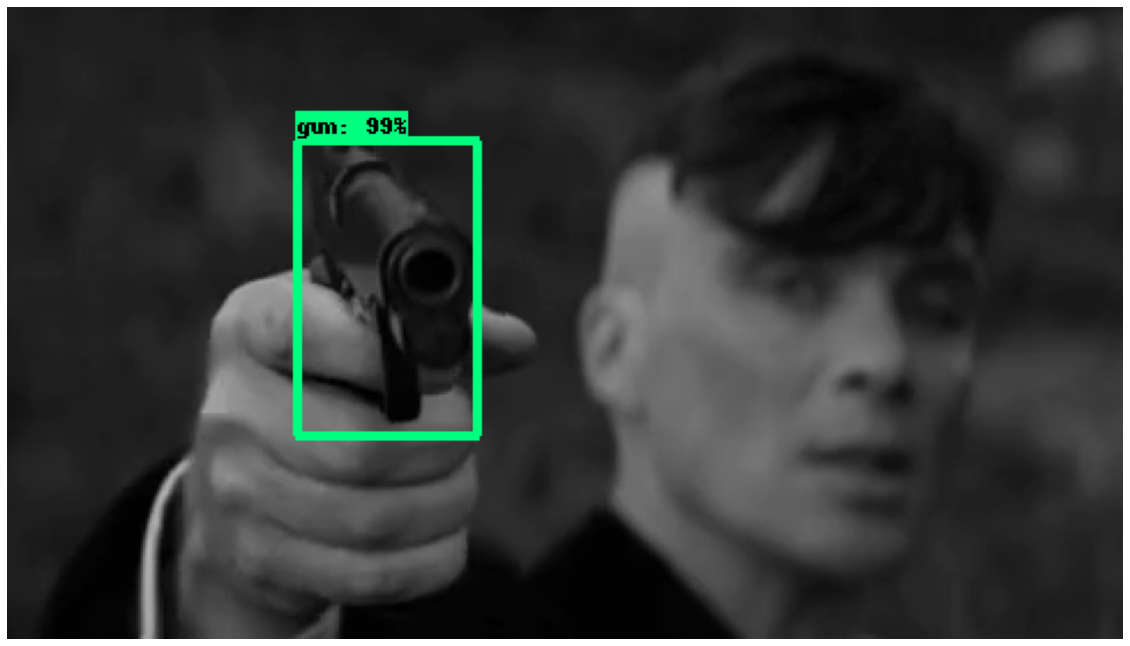

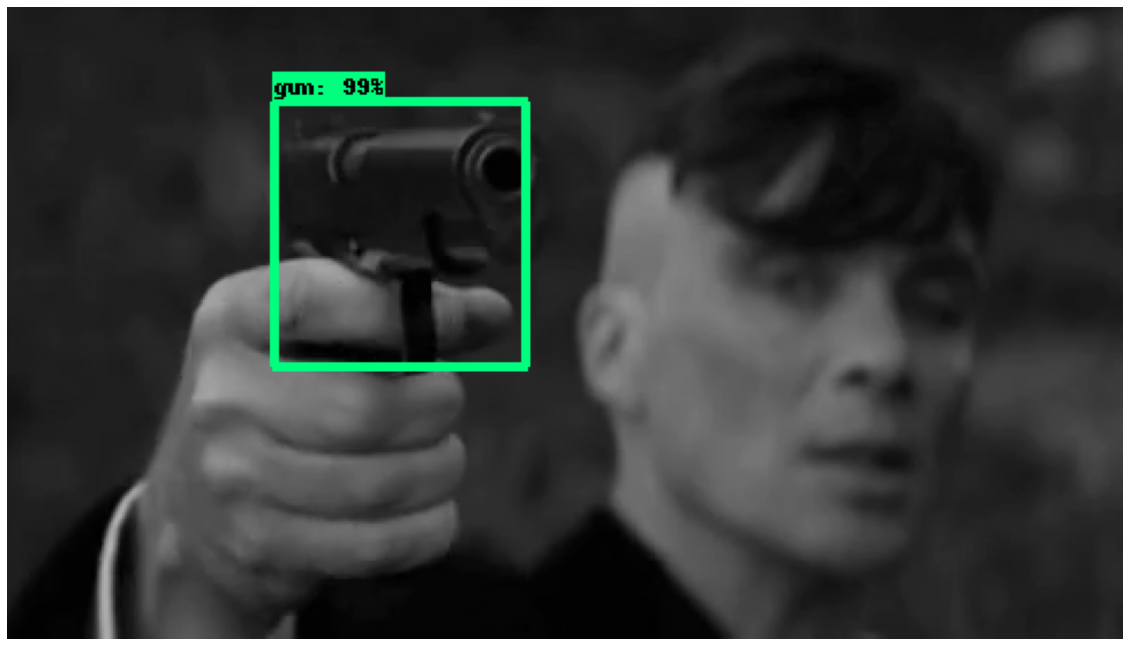

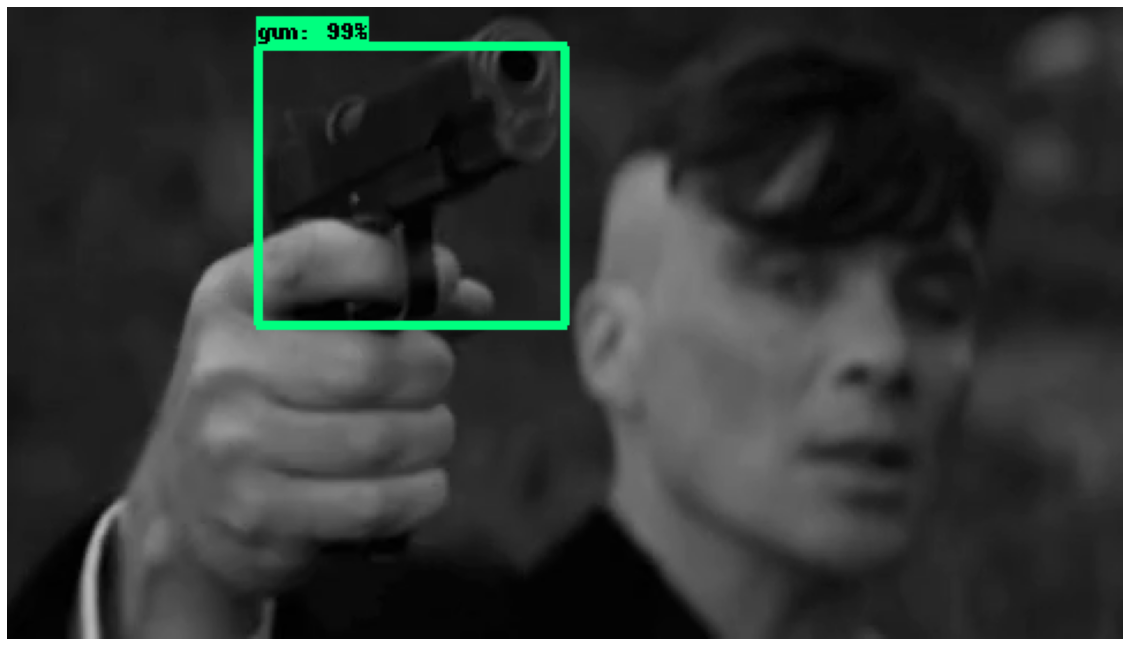

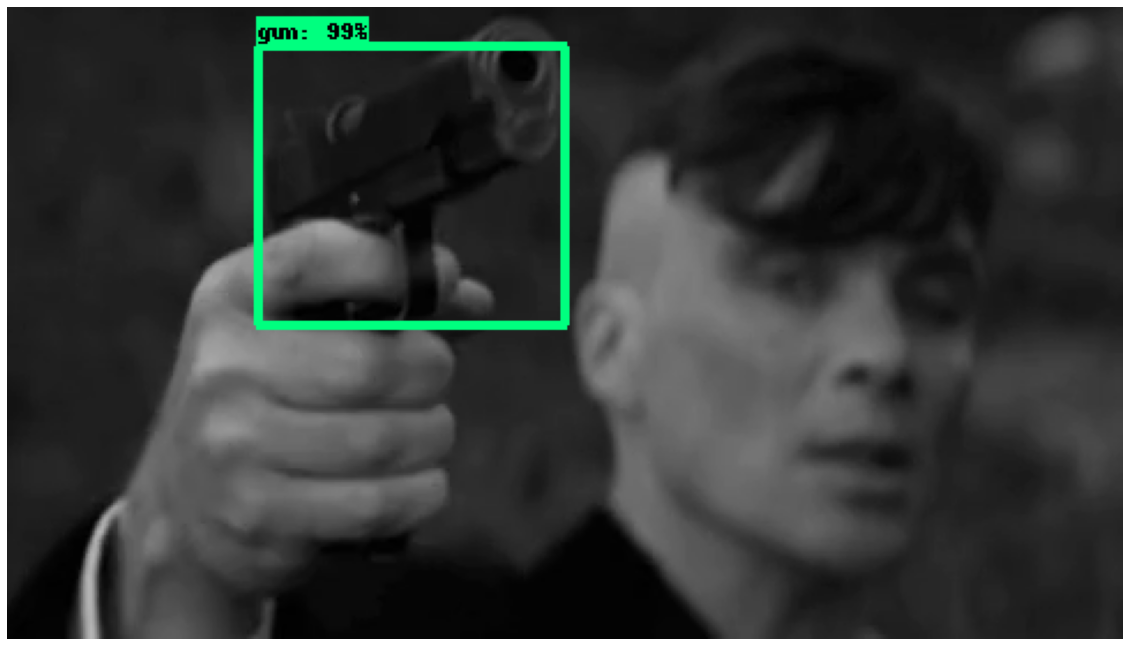

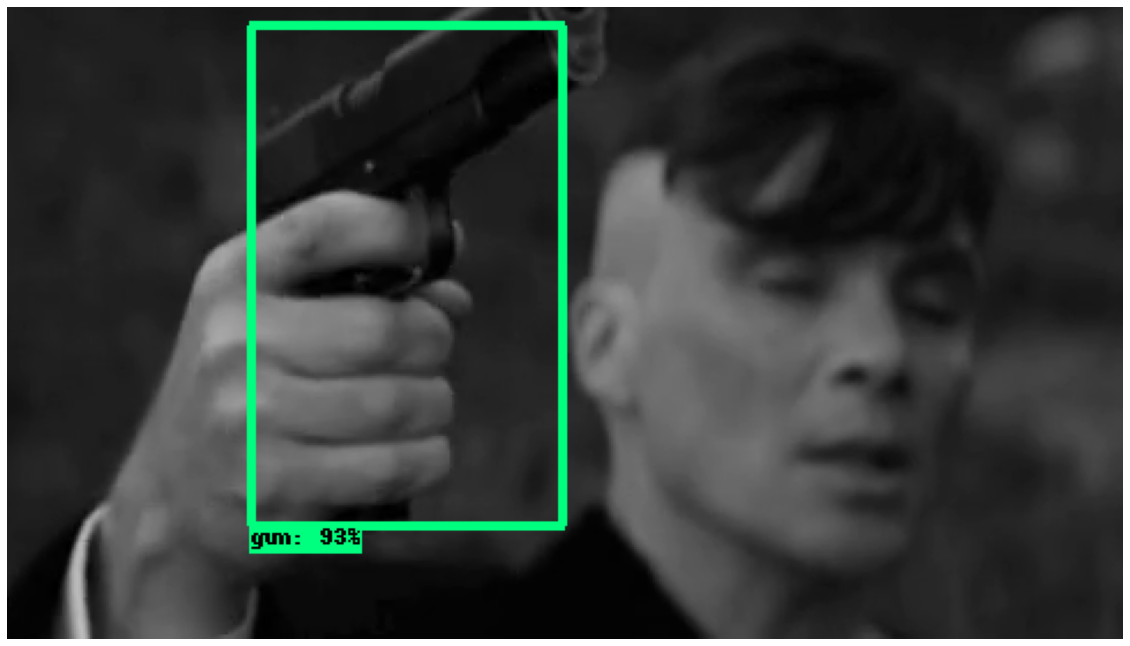

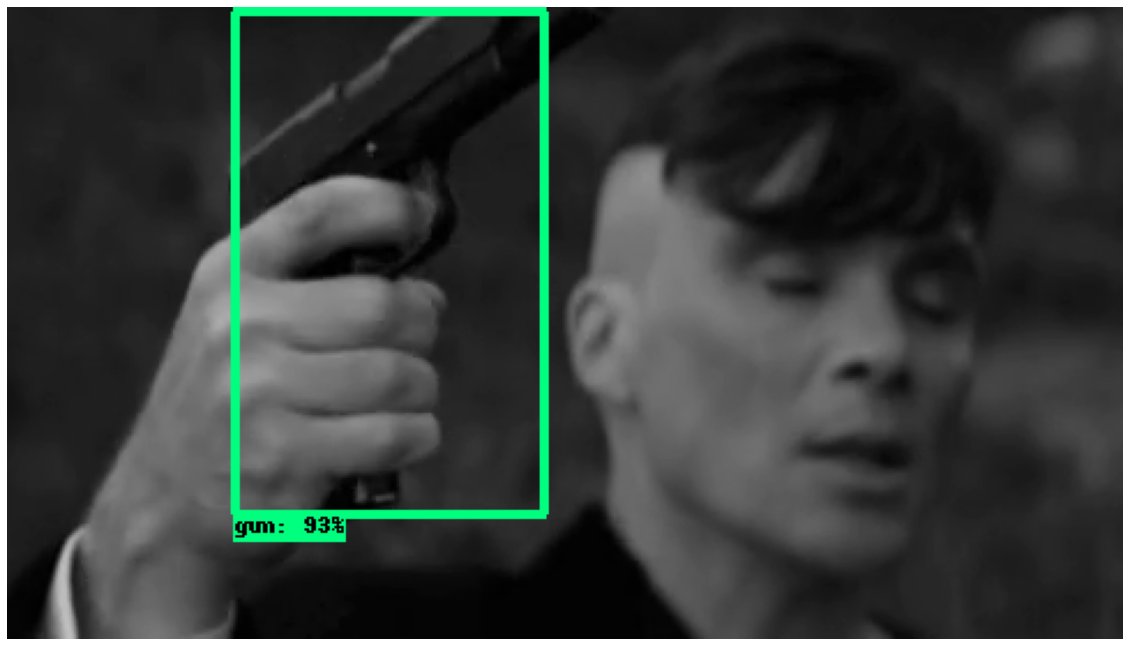

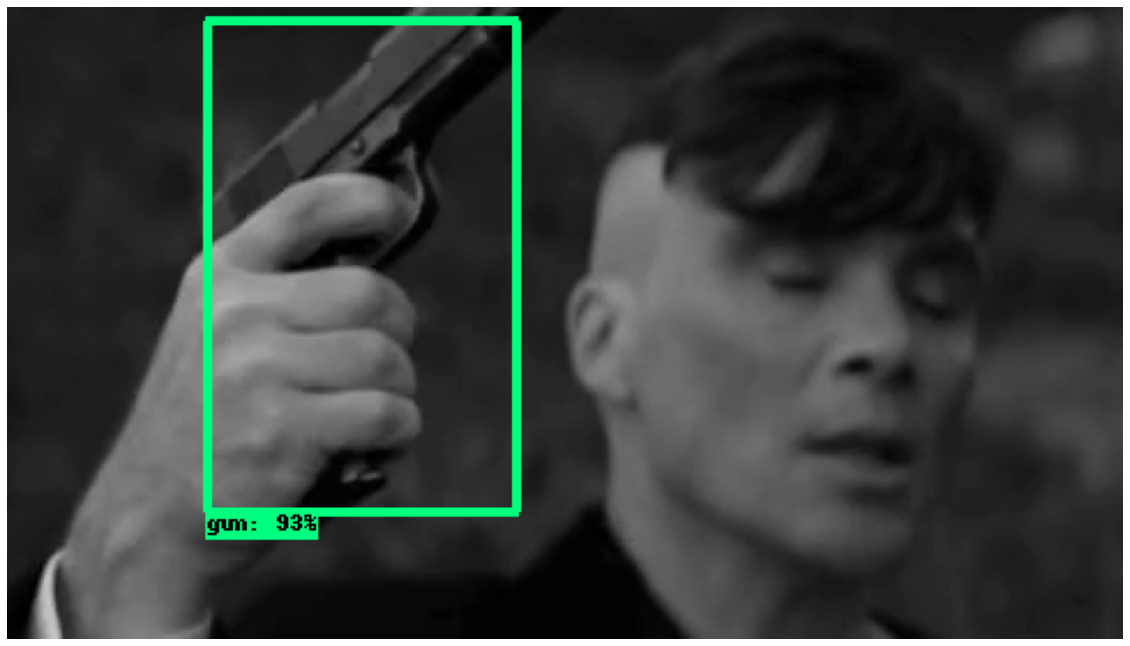

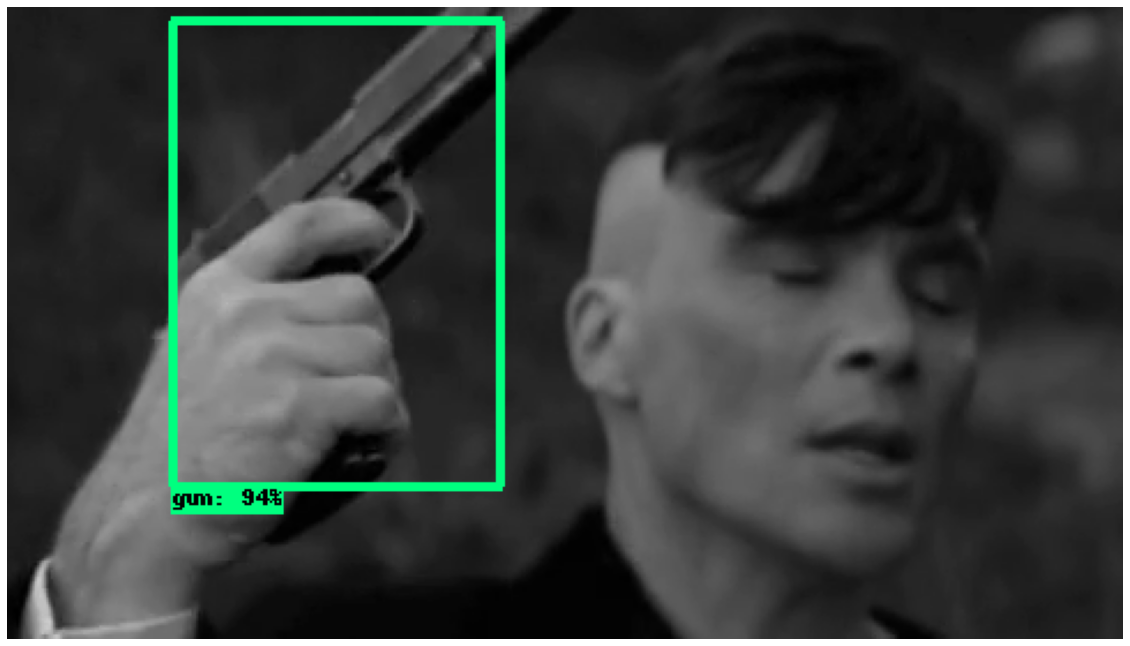

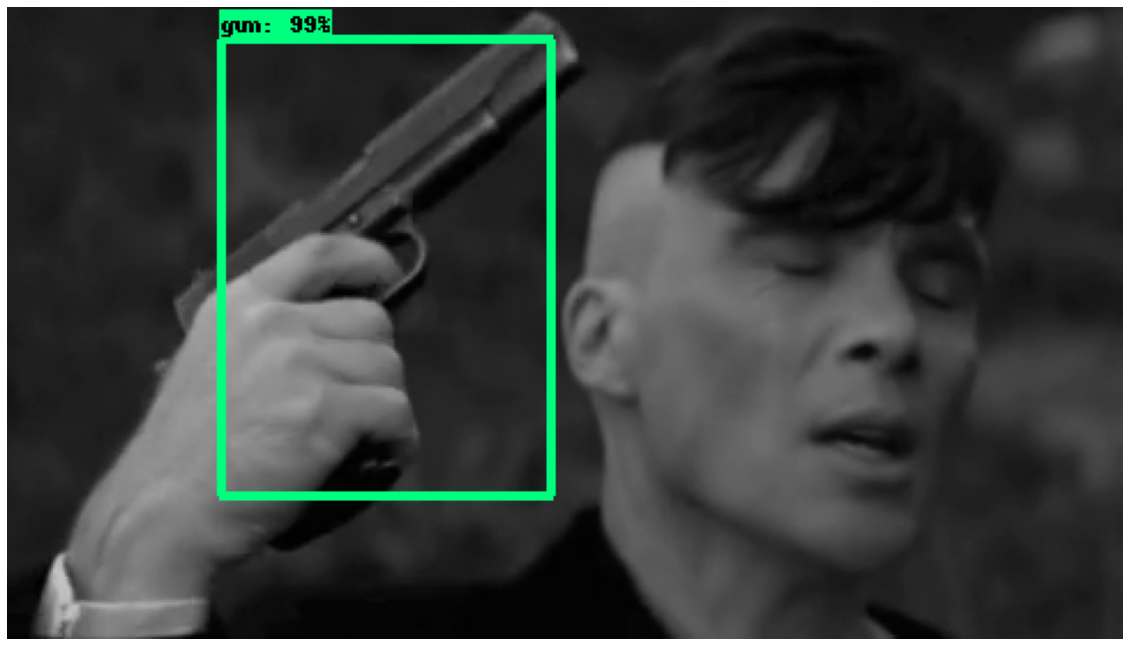

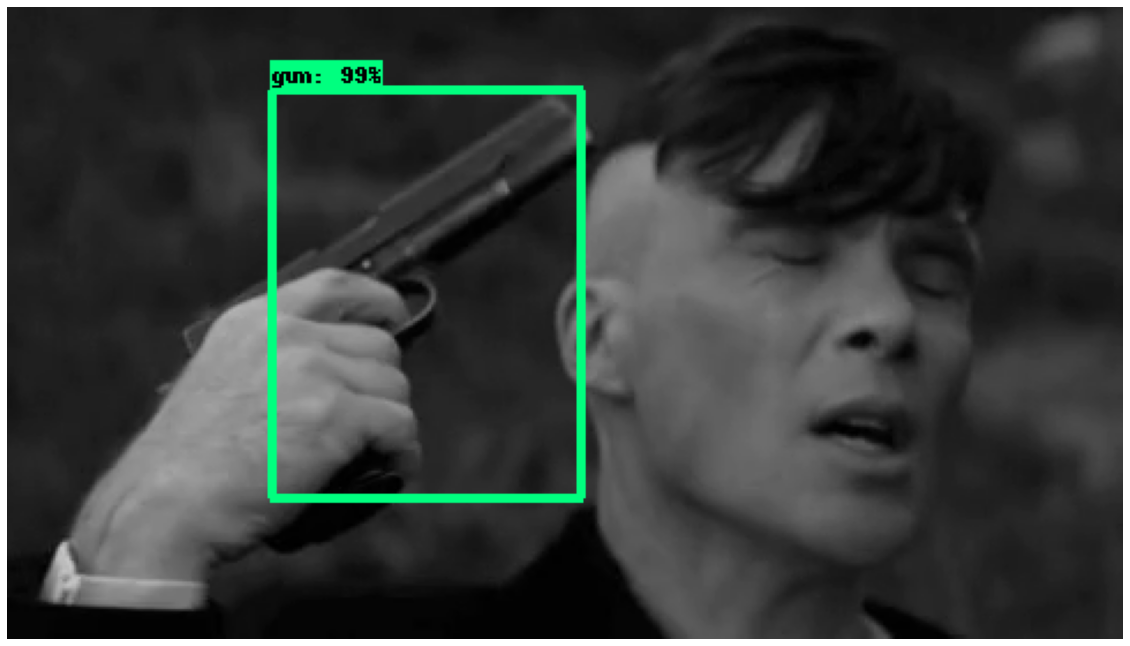

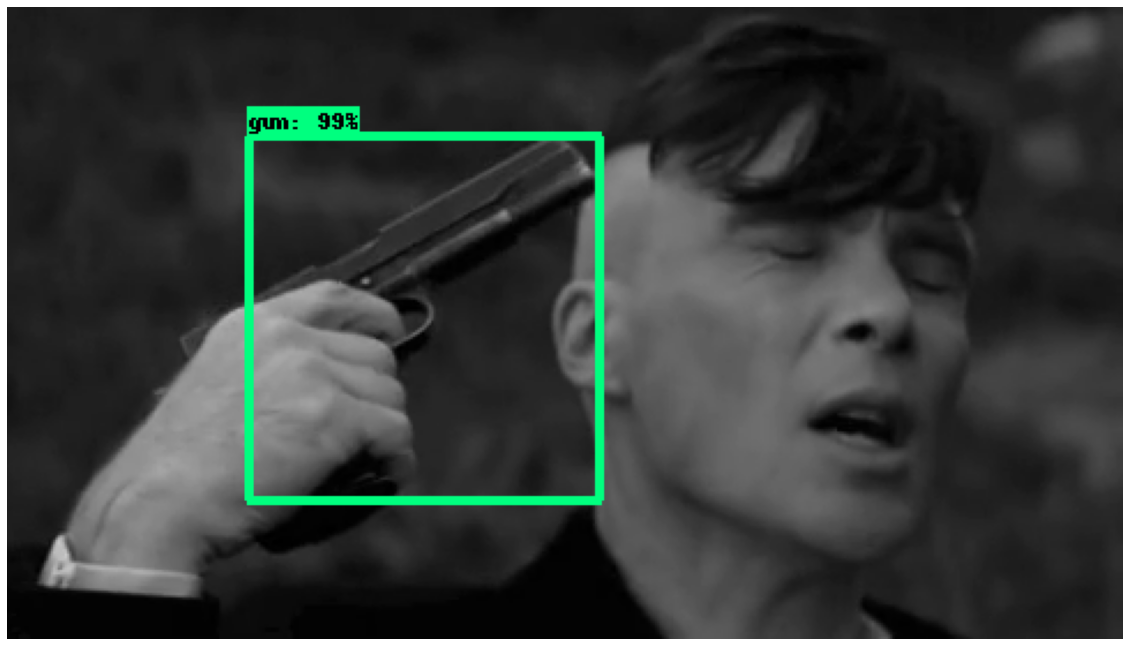

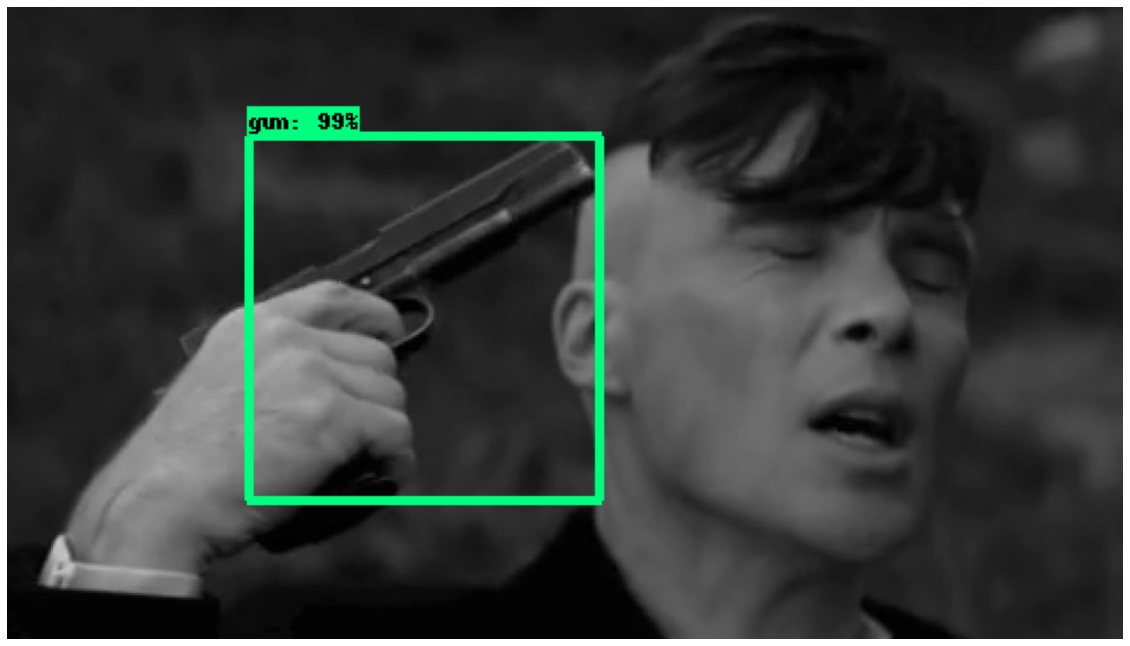

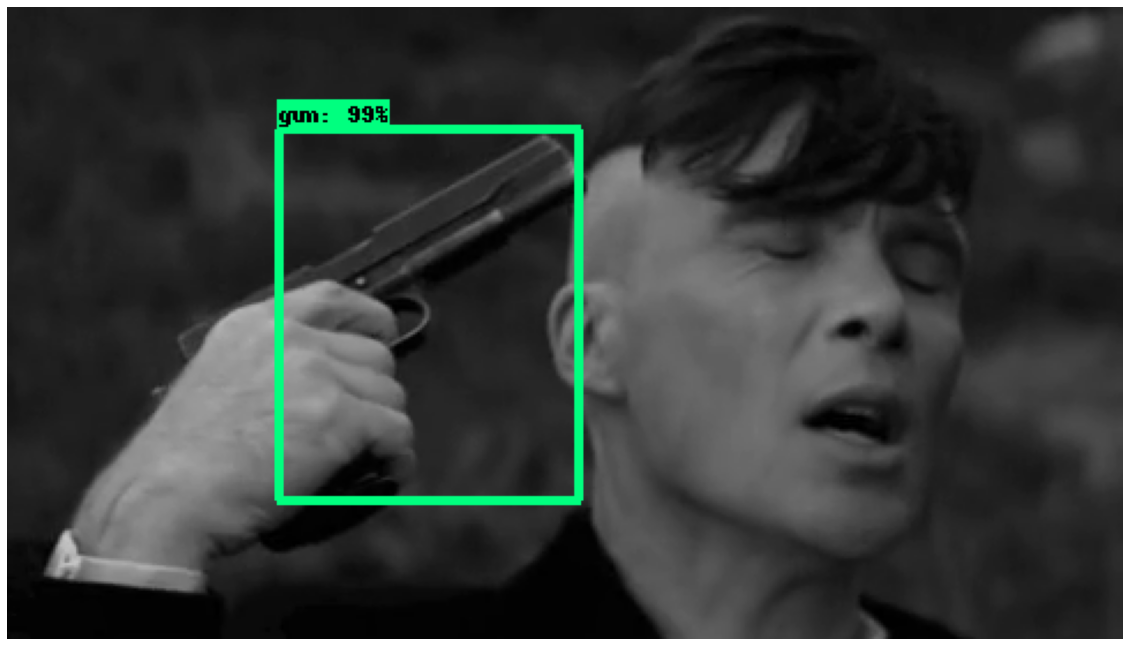

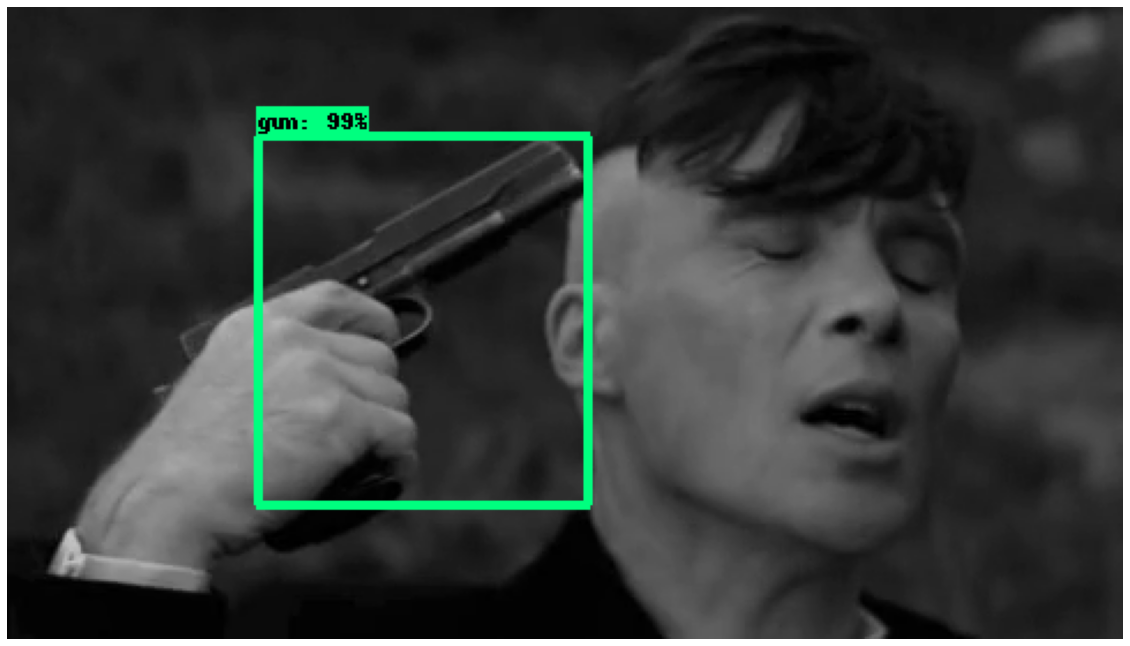

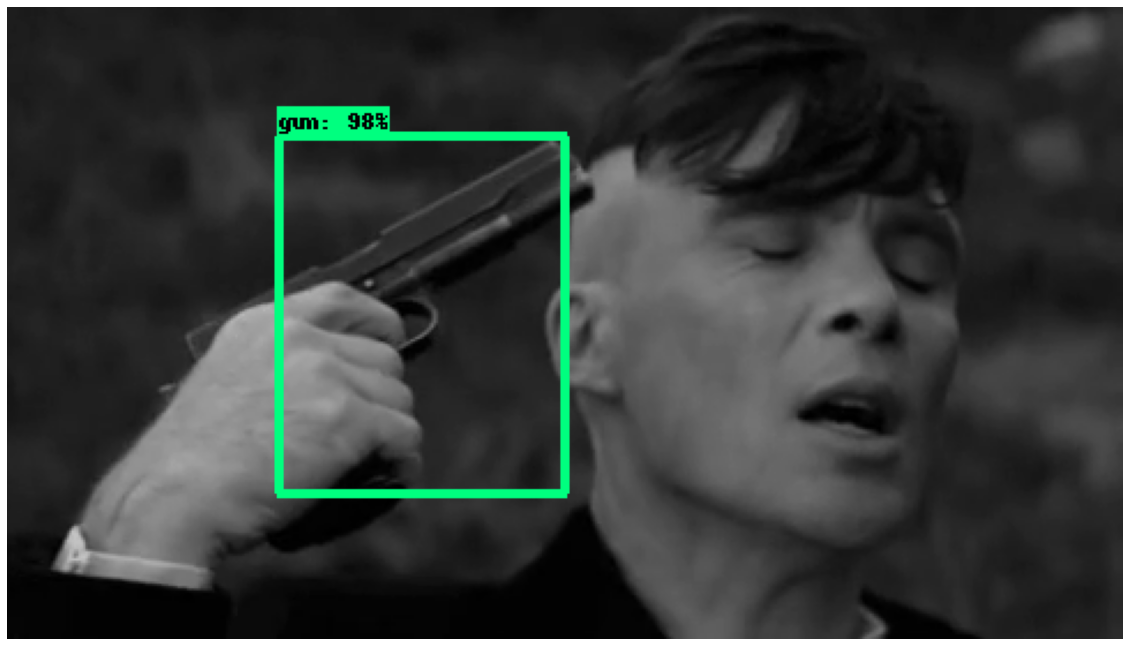

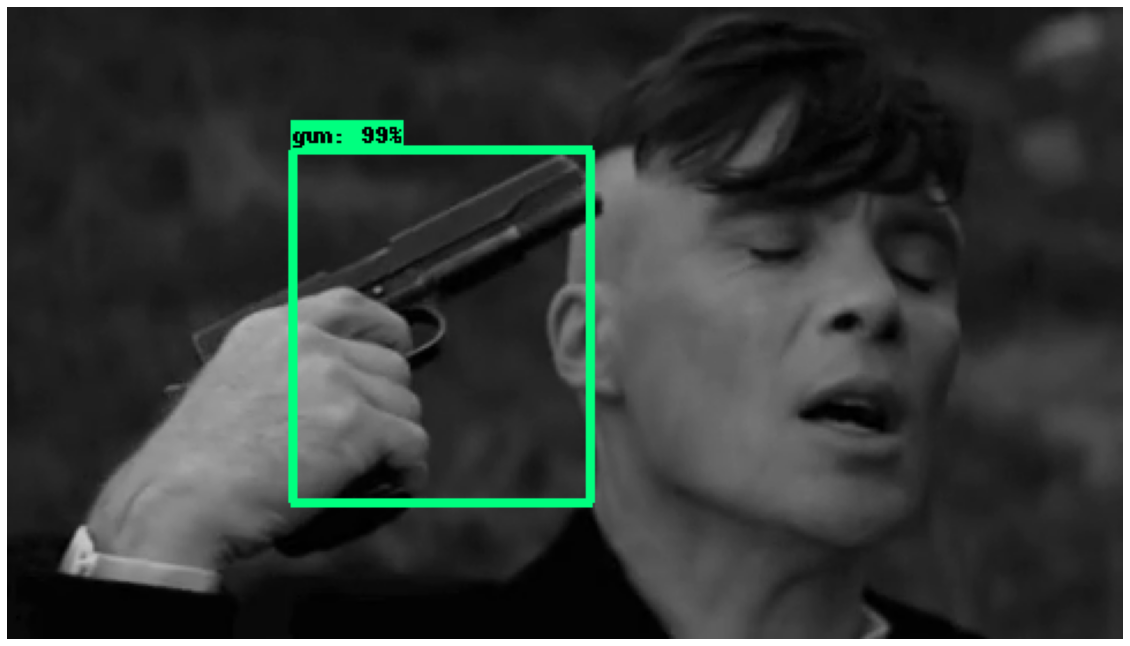

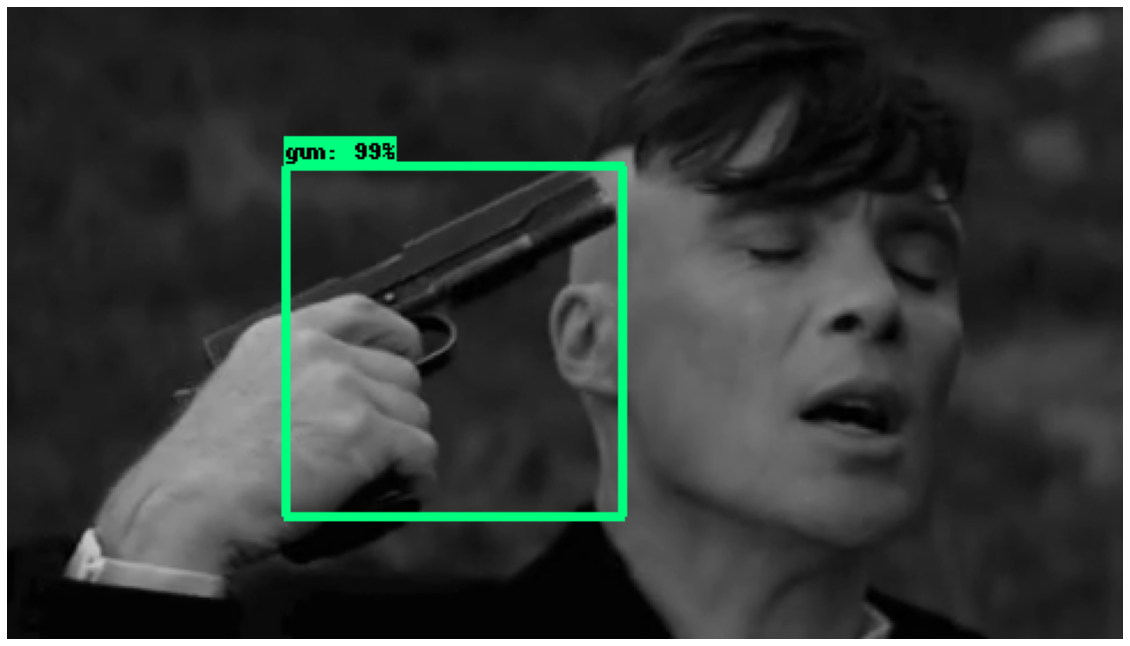

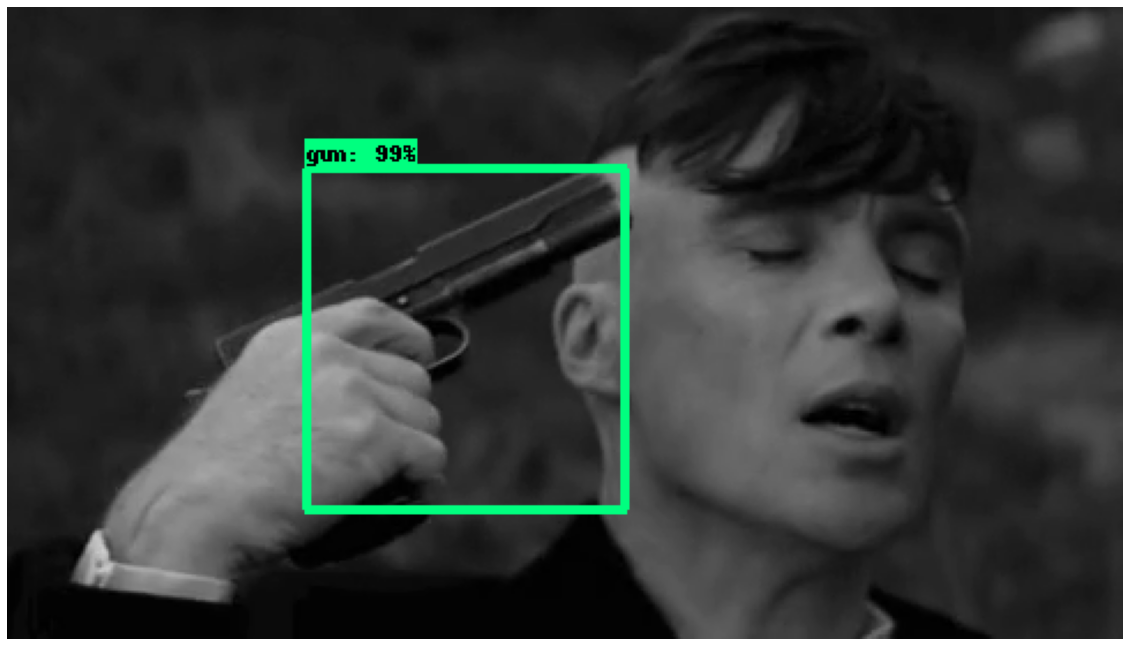

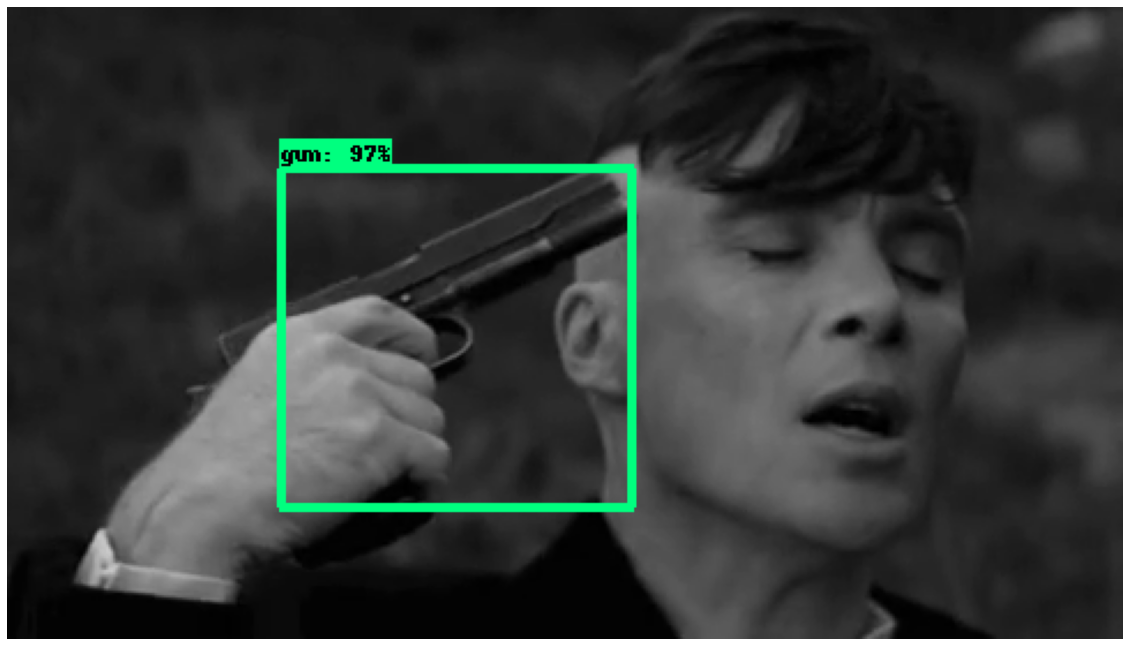

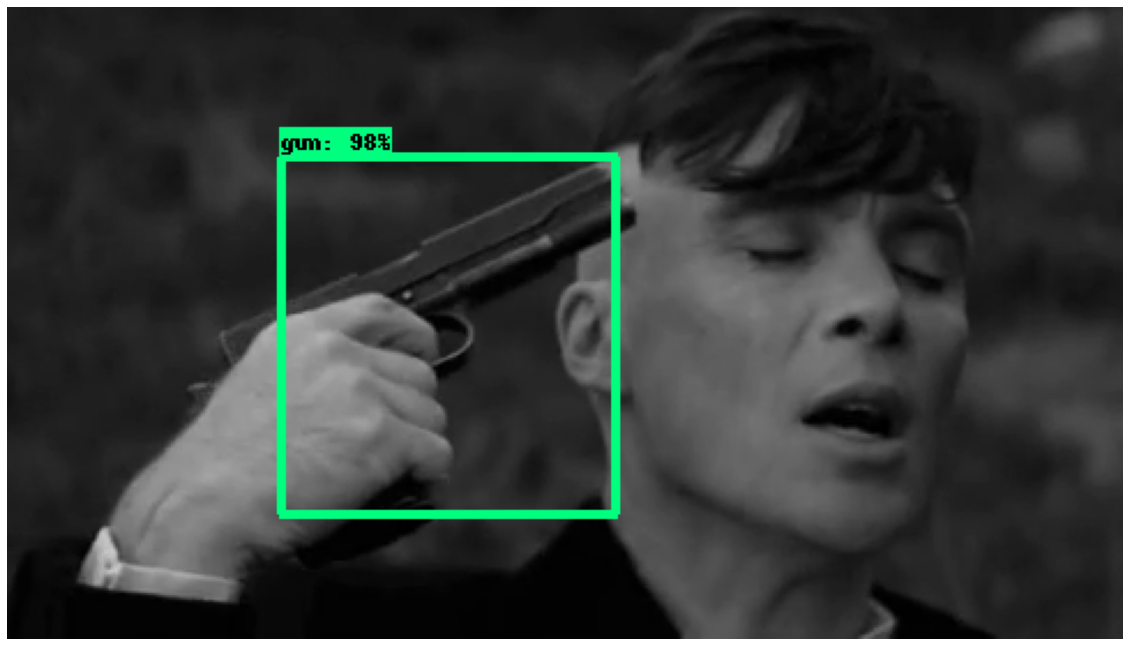

In [84]:
MODEL_DIR_PATH = model_dir_path
PIPELINE_CONFIG = pipeline_config

configs = config_util.get_configs_from_pipeline_file(pipeline_config)
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(MODEL_DIR_PATH, 'ckpt-3')).expect_partial()


category_index = label_map_util.create_category_index_from_labelmap("/content/drive/MyDrive/data/gun-detection.pbtxt")


@tf.function
def detect(input_tensor):
    preprocessed_image, shapes = detection_model.preprocess(input_tensor)
    prediction_dict = detection_model.predict(preprocessed_image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections


def detect_image(img, output_path):
    image_np = np.array(img)

    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'],
        detections['detection_classes'] + label_id_offset,
        detections['detection_scores'],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=5,
        min_score_thresh=.8,
        agnostic_mode=False)

    plt.figure(figsize=(20, 15))
    plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)

    

def detect_video(input_path, output_path):
    cap = cv2.VideoCapture(input_path)
    _, frame = cap.read()
    i = 0
    while True:
        detect_image(frame, output_path=output_path + f"{i}.jpg")
        ret, frame = cap.read()
        if not ret:
            break
        i += 1



if __name__ == '__main__':

    input_path = "tommy.mp4"
    output_path = "output_vid/"
    # check if the input video or image
    if input_path[-3:] == 'jpg' or input_path[-3:] == 'png' or input_path == 'jpeg':
        img = cv2.imread(input_path)
        detect_image(img, output_path=output_path+'img.jpg')
    else:
        detect_video(input_path, output_path)

In [85]:
for image in os.listdir("output_vid/"):
    if len(image) == 5:
        os.rename(f"output_vid/{image}", f"output_vid/0{image}")

In [86]:
import cv2
import numpy as np
import glob

img_array = []
for filename in sorted(glob.glob('output_vid/*.jpg')):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)


out = cv2.VideoWriter('tommy.avi',cv2.VideoWriter_fourcc(*'DIVX'), 10, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

In [77]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('tommy_result.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML("""
<video width=800 controls>
    <source src="%s" type="video/mp4">
</video>
""" % data_url)